In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from qiskit import IBMQ
from qiskit_experiments.framework import ExperimentData
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_research.mzm_generation import KitaevHamiltonianAnalysis

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')

In [3]:
db_experiment_id = '01ee8b02-81ae-419c-9453-996871f164c8'
# db_experiment_id = '000cdc2b-b523-4631-9b7f-48e439484230'
# db_experiment_id = '134978a1-ea17-41b5-9e59-fb3f77bf6f30'  # 3 qubits
# db_experiment_id = 'f6637a82-afe1-44bd-adce-188bf0ddd2a6'  # 4 qubits

data = ExperimentData.load(db_experiment_id, provider.service('experiment'))

In [4]:
%%time
experiment_id = data.metadata["experiment_id"]
qubits = data.metadata["qubits"]
n_modes = len(qubits)
tunneling_values = data.metadata["tunneling_values"]
superconducting_values = data.metadata["superconducting_values"]
chemical_potential_values = data.metadata["chemical_potential_values"]

# run analysis
analysis = KitaevHamiltonianAnalysis()
data = analysis.run(data)

# load results
fidelity_witness_avg_raw, fidelity_witness_stddev_raw = data.analysis_results('fidelity_witness_avg_raw').value
fidelity_witness_avg_mem, fidelity_witness_stddev_mem = data.analysis_results('fidelity_witness_avg_mem').value
fidelity_witness_avg_ps, fidelity_witness_stddev_ps = data.analysis_results('fidelity_witness_avg_ps').value
fidelity_witness_avg_pur, fidelity_witness_stddev_pur = data.analysis_results('fidelity_witness_avg_pur').value

energy_exact = data.analysis_results('energy_exact').value
energy_raw = data.analysis_results('energy_raw').value
energy_mem = data.analysis_results('energy_mem').value
energy_ps = data.analysis_results('energy_ps').value
energy_pur = data.analysis_results('energy_pur').value

edge_correlation_exact = data.analysis_results('edge_correlation_exact').value
edge_correlation_raw = data.analysis_results('edge_correlation_raw').value
edge_correlation_mem = data.analysis_results('edge_correlation_mem').value
edge_correlation_ps = data.analysis_results('edge_correlation_ps').value
edge_correlation_pur = data.analysis_results('edge_correlation_pur').value

parity_exact = data.analysis_results('parity_exact').value
parity_raw = data.analysis_results('parity_raw').value
parity_mem = data.analysis_results('parity_mem').value
parity_ps = data.analysis_results('parity_ps').value

number_exact = data.analysis_results('number_exact').value
number_raw = data.analysis_results('number_raw').value
number_mem = data.analysis_results('number_mem').value
number_ps = data.analysis_results('number_ps').value
number_pur = data.analysis_results('number_pur').value

energy_error_raw, energy_error_stddev_raw = data.analysis_results('energy_error_raw').value
energy_error_mem, energy_error_stddev_mem = data.analysis_results('energy_error_mem').value
energy_error_ps, energy_error_stddev_ps = data.analysis_results('energy_error_ps').value
energy_error_pur, energy_error_stddev_pur = data.analysis_results('energy_error_pur').value

# site_correlation_exact = data.analysis_results('site_correlation_exact').value

# create plot directory
os.makedirs(f'plots/{experiment_id}', exist_ok=True)

# set plot options
dpi = 150
filetype = 'png'

/home/kjs/projects/qiskit-research/qiskit_research/mzm_generation/utils.py:51: UserWarning: The default value for `display_format` will be changed from 'dense' to 'sparse' in version 0.3.0. Once that happens, you must specify display_format='dense' directly.
  return FermionicOp(f"-_{index}") + FermionicOp(f"+_{index}")


CPU times: user 6.52 s, sys: 657 ms, total: 7.18 s
Wall time: 5.22 s


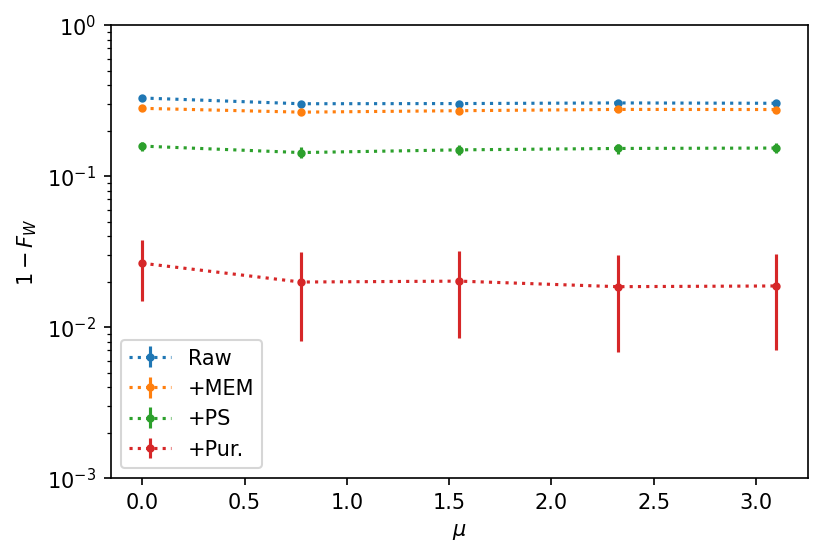

In [5]:
# plot fidelity witness
fig, ax = plt.subplots(dpi=dpi)
ax.errorbar(
    chemical_potential_values,
    1 - fidelity_witness_avg_raw,
    yerr=2 * fidelity_witness_stddev_raw,
    fmt=".:",
    label="Raw",
)
ax.errorbar(
    chemical_potential_values,
    1 - fidelity_witness_avg_mem,
    yerr=2 * fidelity_witness_stddev_mem,
    fmt=".:",
    label="+MEM",
)
ax.errorbar(
    chemical_potential_values,
    1 - fidelity_witness_avg_ps,
    yerr=2 * fidelity_witness_stddev_ps,
    fmt=".:",
    label="+PS",
)
ax.errorbar(
    chemical_potential_values,
    1 - fidelity_witness_avg_pur,
    yerr=2 * fidelity_witness_stddev_pur,
    fmt=".:",
    label="+Pur.",
)
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$1 - F_W$")
ax.set_yscale('log')
ax.set_ylim(1e-3, 1)
ax.legend()

data.add_figures(fig, 'fidelity_witness', overwrite=True)
plt.savefig(f'plots/{experiment_id}/fidelity_witness.{filetype}')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


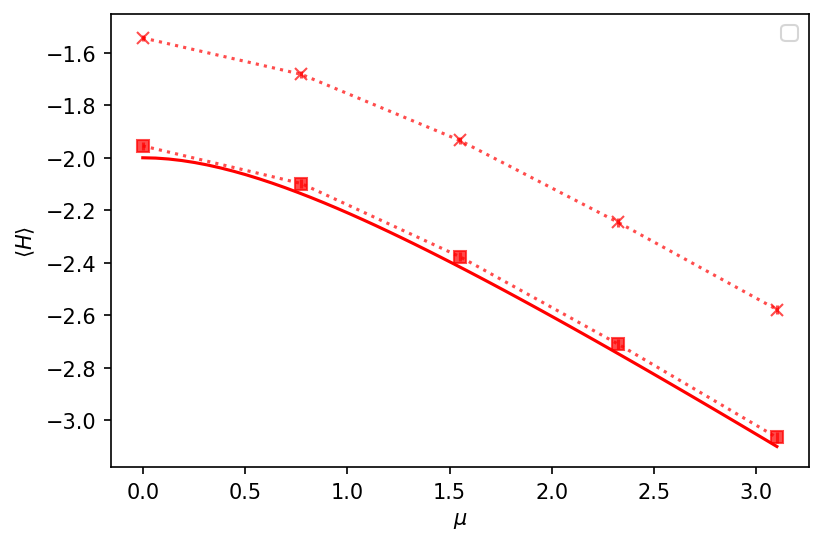

In [6]:
# plot energy
fig, ax = plt.subplots(dpi=dpi)
#occupied_orbitals_list = [(), (0,)]
occupied_orbitals_list = [tuple(o) for o in data.metadata["occupied_orbitals_list"]]
for occupied_orbitals in occupied_orbitals_list:
    energies, xvals = energy_exact[occupied_orbitals]
    label = "Ideal" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(
        xvals, energies, label=label, color=color
    )
for occupied_orbitals in occupied_orbitals_list:
    energies, stddevs = energy_raw[occupied_orbitals]
    label = "Raw" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt="x:",
        label=label,
        color=color,
        alpha=0.7,
    )
for occupied_orbitals in occupied_orbitals_list:
    energies, stddevs = energy_pur[occupied_orbitals]
    label = "Mit." if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt="s:",
        label=label,
        color=color,
        alpha=0.7,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle H \rangle$")
ax.legend()

data.add_figures(fig, 'energy', overwrite=True)
plt.savefig(f'plots/{experiment_id}/energy.{filetype}')
plt.show()

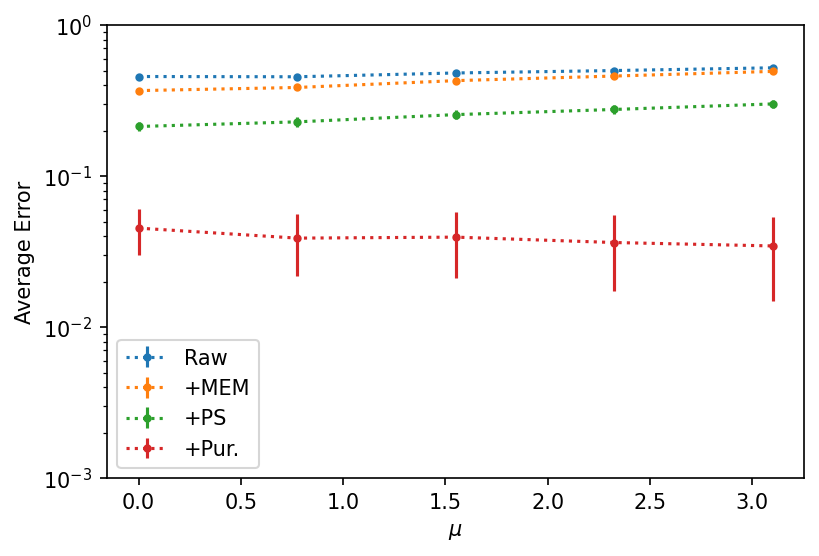

In [7]:
# plot average error in energy
fig, ax = plt.subplots(dpi=dpi)
ax.errorbar(
    chemical_potential_values,
    energy_error_raw,
    yerr=2 * energy_error_stddev_raw,
    fmt=".:",
    label="Raw",
)
ax.errorbar(
    chemical_potential_values,
    energy_error_mem,
    yerr=2 * energy_error_stddev_mem,
    fmt=".:",
    label="+MEM",
)
ax.errorbar(
    chemical_potential_values,
    energy_error_ps,
    yerr=2 * energy_error_stddev_ps,
    fmt=".:",
    label="+PS",
)
ax.errorbar(
    chemical_potential_values,
    energy_error_pur,
    yerr=2 * energy_error_stddev_pur,
    fmt=".:",
    label="+Pur.",
)
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"Average Error")
ax.set_yscale('log')
ax.set_ylim(1e-3, 1)
ax.legend()

data.add_figures(fig, 'energy_error', overwrite=True)
plt.savefig(f'plots/{experiment_id}/energy_error.{filetype}')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


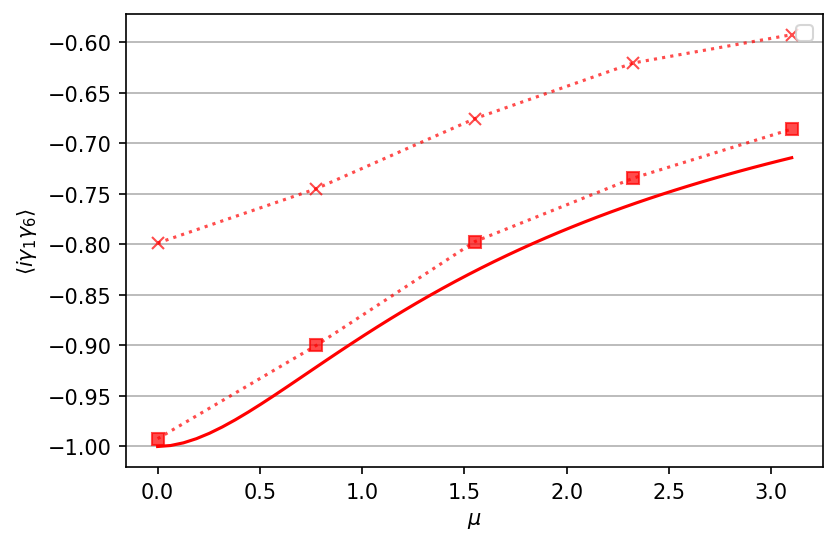

In [8]:
# plot edge correlation
fig, ax = plt.subplots(dpi=dpi)
for occupied_orbitals, (edge_correlations, xvals) in edge_correlation_exact.items():
    label = "Ideal" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(xvals, edge_correlations, label=label, color=color)
for occupied_orbitals, (edge_correlations, stddevs) in edge_correlation_raw.items():
    label = "Raw" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        edge_correlations,
        yerr=2 * np.array(stddevs),
        fmt="x:",
        label=label,
        color=color,
        alpha=0.7
    )
for occupied_orbitals, (edge_correlations, stddevs) in edge_correlation_pur.items():
    label = "Mit." if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        edge_correlations,
        yerr=2 * np.array(stddevs),
        fmt="s:",
        label=label,
        color=color,
        alpha=0.7
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle i \gamma_1 \gamma_6 \rangle$")
ax.grid(axis='y')
ax.legend()

data.add_figures(fig, 'edge_correlation', overwrite=True)
plt.savefig(f'plots/{experiment_id}/edge_correlation.{filetype}')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


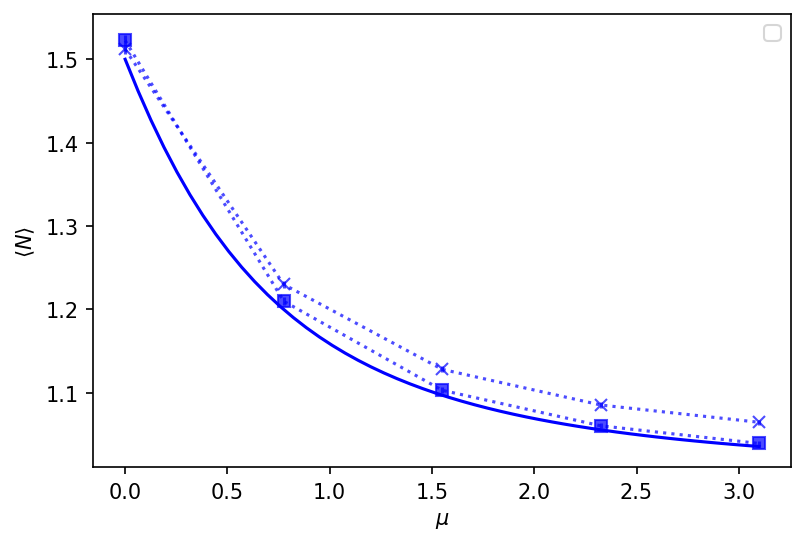

In [9]:
# plot number
fig, ax = plt.subplots(dpi=dpi)
colors = {
    (): "darkblue",
    (0,): "blue",
    (1,): "cyan",
    (2,): "greenyellow",
    (0, 1): "green",
    (0, 2): "orange",
    (1, 2): "red",
    (0, 1, 2): "violet",
    (0, 1, 2, 3): "black",
}
for occupied_orbitals, (numbers, xvals) in number_exact.items():
    label = "Ideal" if not occupied_orbitals else None
    ax.plot(
        xvals,
        numbers,
        label=label,
        color=colors[occupied_orbitals],
    )
for occupied_orbitals, (numbers, stddevs) in number_raw.items():
    label = "Raw" if not occupied_orbitals else None
    ax.errorbar(
        chemical_potential_values,
        numbers,
        yerr=2 * np.array(stddevs),
        fmt="x:",
        label=label,
        color=colors[occupied_orbitals],
        alpha=0.7,
    )
for occupied_orbitals, (numbers, stddevs) in number_pur.items():
    label = "Mit." if not occupied_orbitals else None
    ax.errorbar(
        chemical_potential_values,
        numbers,
        yerr=2 * np.array(stddevs),
        fmt="s:",
        label=label,
        color=colors[occupied_orbitals],
        alpha=0.7,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle N \rangle$")
ax.legend()

data.add_figures(fig, 'number', overwrite=True)
plt.savefig(f'plots/{experiment_id}/number.{filetype}')
plt.show()

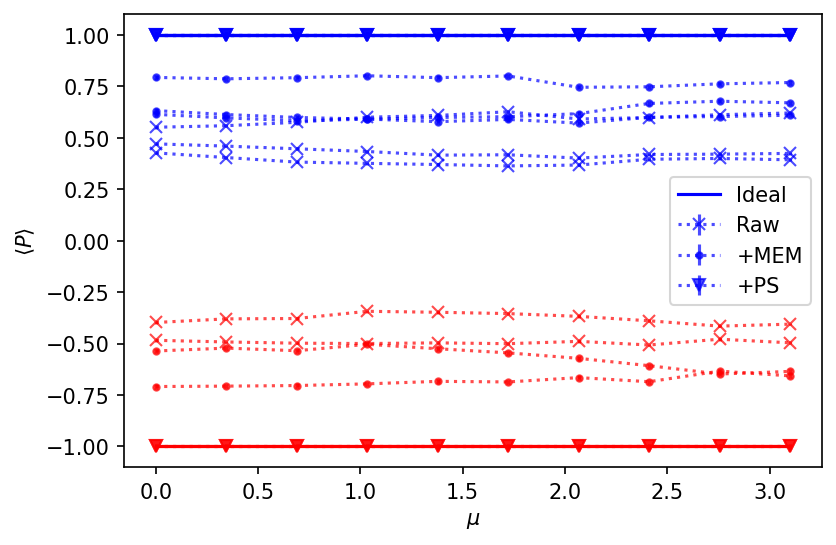

In [10]:
# plot parity
fig, ax = plt.subplots(dpi=dpi)
for occupied_orbitals, (parities, xvals) in parity_exact.items():
    label = "Ideal" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(xvals, parities, label=label, color=color)
for occupied_orbitals, (parities, stddevs) in parity_raw.items():
    label = "Raw" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        parities,
        yerr=2 * np.array(stddevs),
        fmt="x:",
        label=label,
        color=color,
        alpha=0.7,
    )
for occupied_orbitals, (parities, stddevs) in parity_mem.items():
    label = "+MEM" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        parities,
        yerr=2 * np.array(stddevs),
        fmt=".:",
        label=label,
        color=color,
        alpha=0.7,
    )
for occupied_orbitals, (parities, stddevs) in parity_ps.items():
    label = "+PS" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        parities,
        yerr=2 * np.array(stddevs),
        fmt="v:",
        label=label,
        color=color,
        alpha=0.7,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle P \rangle$")
ax.set_ylim(-1.1, 1.1)
ax.legend()

data.add_figures(fig, 'parity', overwrite=True)
plt.savefig(f'plots/{experiment_id}/parity.{filetype}')
plt.show()

NameError: name 'site_correlation_exact' is not defined

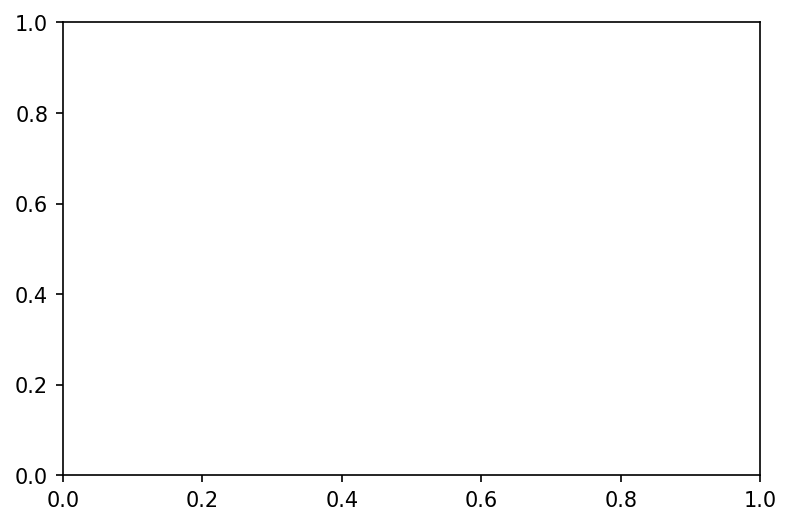

In [11]:
# plot site correlation
fig, ax = plt.subplots(dpi=dpi)
colors = {
    (): "darkblue",
    (0,): "blue",
    (1,): "cyan",
    (2,): "greenyellow",
    (0, 1): "green",
    (0, 2): "orange",
    (1, 2): "red",
    (0, 1, 2): "violet",
    (0, 1, 2, 3): "black",
}
xvals = range(1, 2 * n_modes)
chemical_potential_values, occupied_orbitals_list = zip(*site_correlation_exact.keys())
chemical_potential_values = sorted(set(chemical_potential_values))
occupied_orbitals_list = sorted(set(occupied_orbitals_list))
chemical_potential = chemical_potential_values[2]
for occupied_orbitals in occupied_orbitals_list:
    site_correlations = site_correlation_exact[chemical_potential, occupied_orbitals]
    label = "Ideal" if not occupied_orbitals else None
    ax.plot(
        xvals,
        site_correlations,
        label=label,
        color=colors[occupied_orbitals],
    )
# for occupied_orbitals, (numbers, stddevs) in number_raw.items():
#     label = "Raw" if not occupied_orbitals else None
#     ax.errorbar(
#         chemical_potential_values,
#         numbers,
#         yerr=2 * np.array(stddevs),
#         fmt="x:",
#         label=label,
#         color=colors[occupied_orbitals],
#         alpha=0.7,
#     )
# for occupied_orbitals, (numbers, stddevs) in number_mem.items():
#     label = "+MEM" if not occupied_orbitals else None
#     ax.errorbar(
#         chemical_potential_values,
#         numbers,
#         yerr=2 * np.array(stddevs),
#         fmt=".:",
#         label=label,
#         color=colors[occupied_orbitals],
#         alpha=0.7,
#     )
# for occupied_orbitals, (numbers, stddevs) in number_ps.items():
#     label = "+PS" if not occupied_orbitals else None
#     ax.errorbar(
#         chemical_potential_values,
#         numbers,
#         yerr=2 * np.array(stddevs),
#         fmt="v:",
#         label=label,
#         color=colors[occupied_orbitals],
#         alpha=0.7,
#     )
# for occupied_orbitals, (numbers, stddevs) in number_pur.items():
#     label = "+Pur." if not occupied_orbitals else None
#     ax.errorbar(
#         chemical_potential_values,
#         numbers,
#         yerr=2 * np.array(stddevs),
#         fmt="s:",
#         label=label,
#         color=colors[occupied_orbitals],
#         alpha=0.7,
#     )
ax.set_xlabel("Site")
ax.set_ylabel("Site correlation")
ax.set_xticks(xvals)
ax.legend()

data.add_figures(fig, 'site_correlation_raw_mem', overwrite=True)
plt.show()